First install the required packages
- numpy
- matplotlib
- pandas

In [9]:
%pip install numpy matplotlib pandas


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def create_hilbert_matrix(n: int, dtype=np.float64) -> np.ndarray:
    """Create a Hilbert matrix of size n x n."""
    return np.array(
        [[1 / (i + j + 1) for j in range(n)] for i in range(n)],  # Zero indexed
        dtype=dtype,  # Cast to the desired data type
    )


def decompose_cholesky(A: np.ndarray) -> np.ndarray:
    """Decompose a symmetric positive definite matrix A into L L^T."""

    # Check if A is symmetric and positive definite
    assert A.ndim == 2 and A.shape[0] == A.shape[1], "Matrix must be square"
    assert np.allclose(A, A.T)

    # np.linalg can only support up to float64, not float128
    # For this reason, we only 'raise' a warning here
    if not np.all(np.linalg.eigvals(A.astype(np.float64)) > 0):
        warnings.warn(
            "Matrix may not be positive definite. Numerical errors may occur."
        )

    n: int = A.shape[0]
    L: np.ndarray = np.zeros_like(A)

    for i in range(n):
        for j in range(i + 1):
            # This achieves higher numerical precision since it uses
            # python's float64 (aka float) datatype
            # s = sum(L[i, k] * L[j, k] for k in range(j))

            # We can also formulate this as a dot product
            # Also use np.conj to support complex matrices
            s = np.dot(L[i, :j], np.conj(L[j, :j]))

            if i == j:
                L[i, j] = np.sqrt(A[i, i] - s)

            else:
                L[i, j] = (A[i, j] - s) / L[j, j]

    return L


# Since H8 is a differentiable (linear) function by definition, we can
# compute the conditioning as follows
def matrix_conditioning(H: np.ndarray, ord=2) -> float:
    return np.linalg.norm(H, ord=ord) * np.linalg.norm(np.linalg.inv(H), ord=ord)


def solve_triangular(L: np.ndarray, y: np.ndarray, lower: bool) -> np.ndarray:
    """Solve a system of linear equations where A is a lower or upper triangular matrix."""
    # A x = y, find x

    # Check if A triangular
    if lower:
        assert np.allclose(L, np.tril(L)), "Matrix must be lower triangular"

    else:
        assert np.allclose(L, np.triu(L)), "Matrix must be upper triangular"

    n = L.shape[0]
    x = np.zeros_like(y)

    # And use the gauss algorithm to solve the system
    if lower:
        for i in range(n):
            x[i] = (y[i] - np.dot(L[i, :i], x[:i])) / L[i, i]

    else:
        for i in range(n - 1, -1, -1):
            x[i] = (y[i] - np.dot(L[i, i + 1 :], x[i + 1 :])) / L[i, i]

    return x


def solve_cholesky(A: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Solve a system of linear equations where A is a symmetric positive definite matrix."""

    L = decompose_cholesky(A)

    # Solve L z = y
    z = solve_triangular(L, y, lower=True)

    # Solve L^T x = z
    x = solve_triangular(L.T, z, lower=False)

    return x


In [11]:
for dtype in (np.float32, np.float64):
    for n in (8,):
        H = create_hilbert_matrix(n, dtype=dtype)
        L = decompose_cholesky(H)
        np_chol = np.linalg.cholesky(H)

        print(80 * "-")
        print(
            f"Cholesky of {n}x{n} Hilbert matrix with dtype {dtype}: \n\n"
            "Absolute error: {} \n".format(np.linalg.norm(H - L @ L.T, ord=np.inf))
            + "Relative error: {} \n".format(
                np.linalg.norm(H - L @ L.T, ord=np.inf)
                / np.linalg.norm(H, ord=np.inf)
            )
            + "Absolute error from numpy's implementation: {}".format(
                np.linalg.norm(L - np_chol, ord=np.inf)
            )
        )

--------------------------------------------------------------------------------
Cholesky of 8x8 Hilbert matrix with dtype <class 'numpy.float32'>: 

Absolute error: 7.450580596923828e-09 
Relative error: 2.741343596568413e-09 
Absolute error from numpy's implementation: 0.00025569641729816794
--------------------------------------------------------------------------------
Cholesky of 8x8 Hilbert matrix with dtype <class 'numpy.float64'>: 

Absolute error: 4.163336342344337e-17 
Relative error: 1.5318451719532384e-17 
Absolute error from numpy's implementation: 2.915693402862074e-12


In [12]:
# Calculating the conditioning number kappa of H8
H = create_hilbert_matrix(8)
A = np.random.standard_normal((8, 8))

# We can see that the Hilbert matrix is ill-conditioned
# and so the conditioning number is very large
print(80 * "-" + "\n\n")
print(
    "Comparing conditioning numbers between hilbert matrix and \nsome matrix"
    " consisting of random normally distributed values."
)

for ord in (2, np.inf):
    print(80 * "-" + "\n\n")
    print(
        "Hilbert Matrix: norm order: {} kappa: {}".format(
            ord, matrix_conditioning(H, ord=ord)
        )
    )
    print(
        "Random Matrix: norm order {} kappa {}".format(
            ord, matrix_conditioning(A, ord=ord)
        )
    )

--------------------------------------------------------------------------------


Comparing conditioning numbers between hilbert matrix and 
some matrix consisting of random normally distributed values.
--------------------------------------------------------------------------------


Hilbert Matrix: norm order: 2 kappa: 15257576321.957926
Random Matrix: norm order 2 kappa 40.233644828885225
--------------------------------------------------------------------------------


Hilbert Matrix: norm order: inf kappa: 33872792385.924484
Random Matrix: norm order inf kappa 120.13987666214776


We can clearly see that both in the spectral as well as in the supremum norm,
the hilbert matrix is very ill-conditioned since its kappa is enormous
when comparing it with A's kappa.

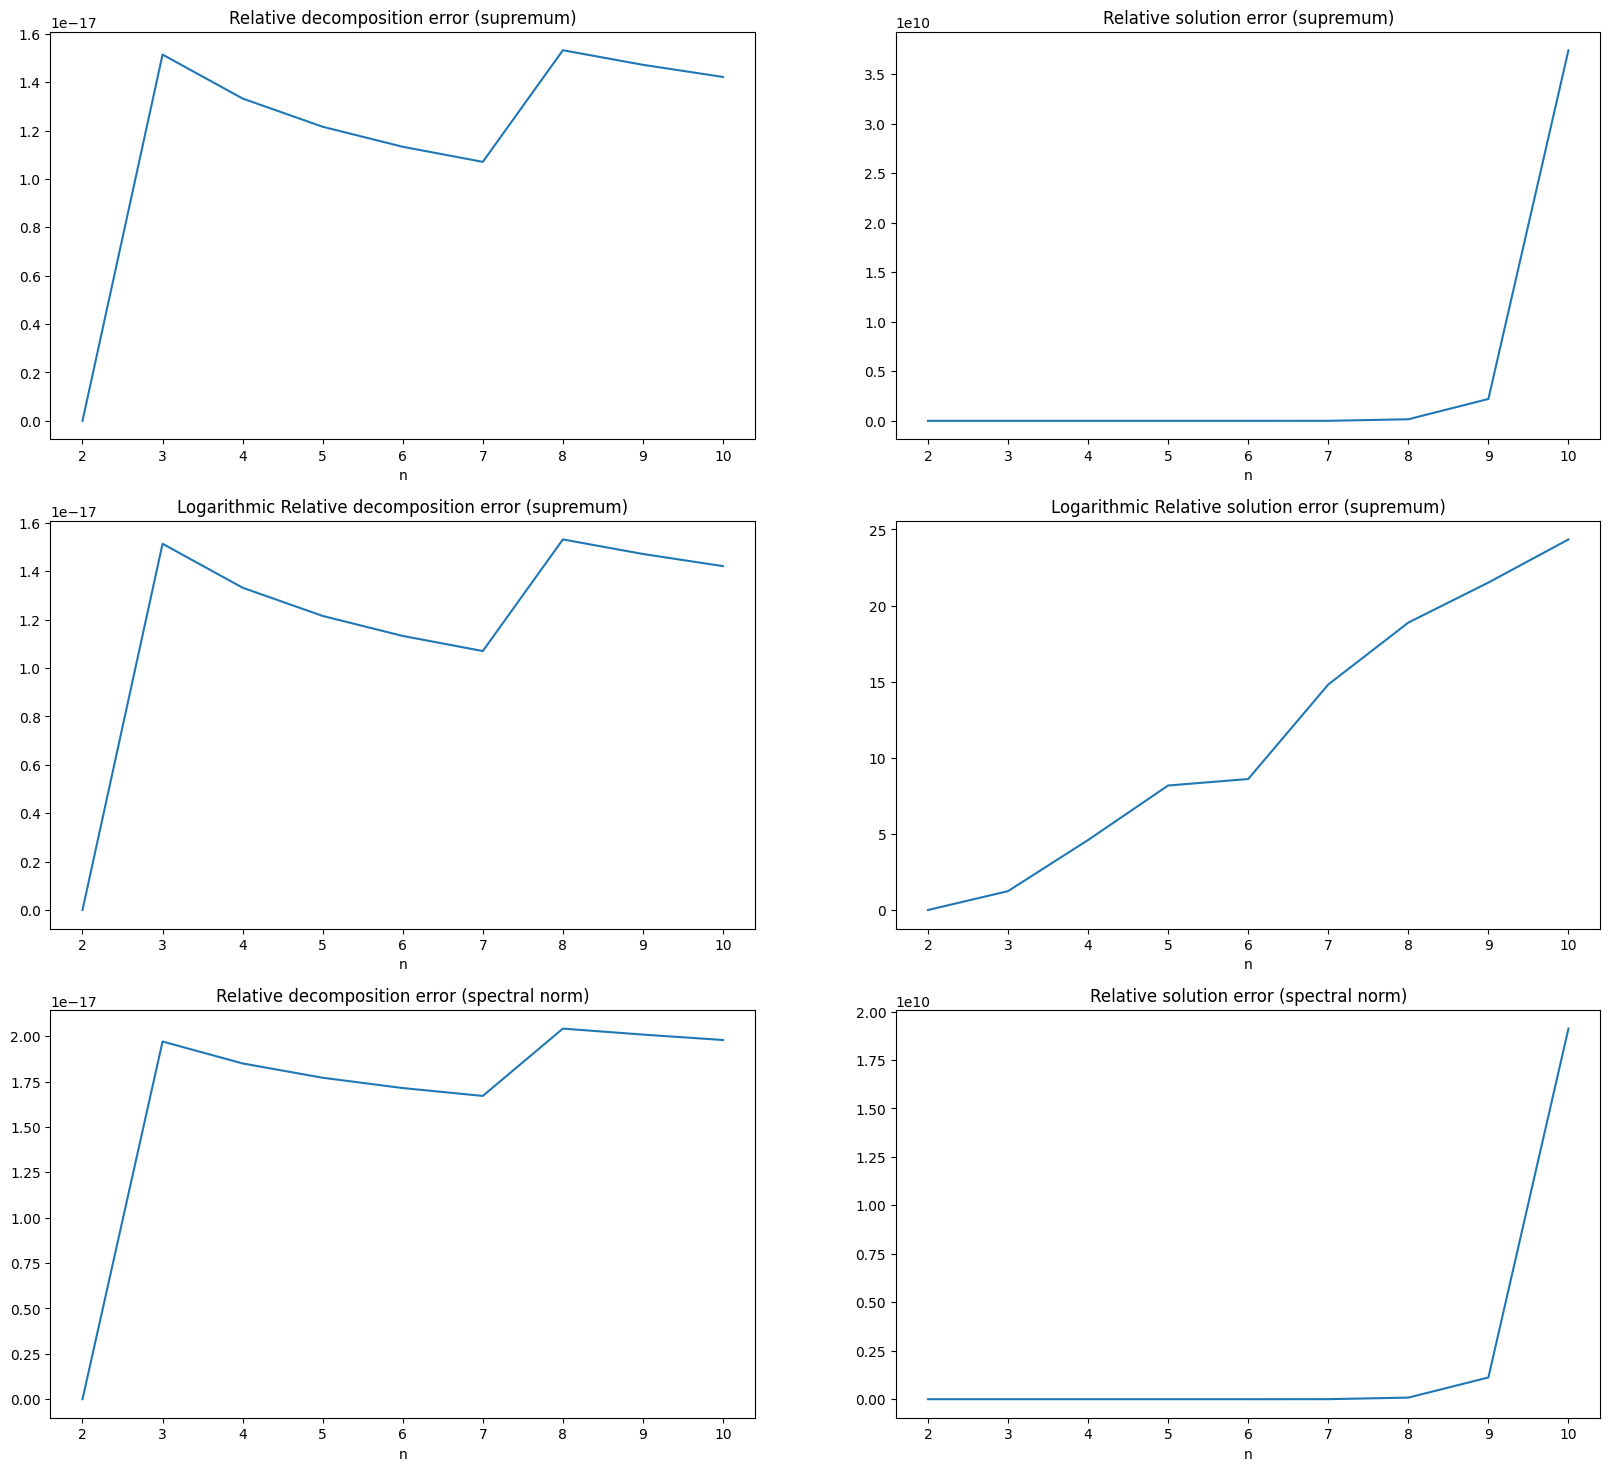

In [13]:
errors: pd.DataFrame = {
    "decomposition_error_sup": [],
    "solve_error_sup": [],
    "decomposition_error_spectral": [],
    "solve_error_spectral": [],
}

for n in range(2, 11):
    H = create_hilbert_matrix(n, dtype=np.float64)
    b = np.sum(H, axis=0)
    delta_b = np.random.standard_normal(n)

    scale_before = np.linalg.norm(delta_b, ord=np.inf) / np.linalg.norm(b, ord=np.inf)

    # Scale delta to yield the 1% perturbation as required
    delta_b *= 0.01 / scale_before
    scale = np.linalg.norm(delta_b, ord=np.inf) / np.linalg.norm(b, ord=np.inf)

    # And now perturb the original vector b
    perturbed_b = b + delta_b

    # And now solve the system of linear equations
    # Hx = b + delta_b = perturbed_b
    L = decompose_cholesky(H)
    x = solve_cholesky(H, perturbed_b)
    y = np.ones_like(x)  # The actual solution for our problem obviously

    errors["decomposition_error_sup"].append(
        np.linalg.norm(H - L @ L.T, ord=np.inf) / np.linalg.norm(H, ord=np.inf)
    )
    errors["solve_error_sup"].append(
        np.linalg.norm(x - np.ones_like(x), ord=np.inf) / np.linalg.norm(y, ord=np.inf)
    )

    errors["decomposition_error_spectral"].append(
        np.linalg.norm(H - L @ L.T, ord=2) / np.linalg.norm(H, ord=2)
    )
    errors["solve_error_spectral"].append(
        np.linalg.norm(x - np.ones_like(x), ord=2) / np.linalg.norm(y, ord=2)
    )

errors = pd.DataFrame(errors).assign(n=np.arange(2, 11)).set_index("n")

fig, axs = plt.subplots(3, 2, figsize=(20, 18))
errors["decomposition_error_sup"].plot(
    ax=axs[0, 0], title="Relative decomposition error (supremum)"
)
errors["solve_error_sup"].plot(ax=axs[0, 1], title="Relative solution error (supremum)")

np.log1p(errors["decomposition_error_sup"]).plot(
    ax=axs[1, 0], title="Logarithmic Relative decomposition error (supremum)"
)
np.log1p(errors["solve_error_sup"]).plot(
    ax=axs[1, 1], title="Logarithmic Relative solution error (supremum)"
)

errors["decomposition_error_spectral"].plot(
    ax=axs[2, 0], title="Relative decomposition error (spectral norm)"
)
errors["solve_error_spectral"].plot(
    ax=axs[2, 1], title="Relative solution error (spectral norm)"
)

plt.show()

Note that in the second row, we computed
$$
log_{10} (1 + error)
$$
so for values close to zero (which the decomposition errors are),
the graph will just look very similar.

However we can see very nicely that the solution error grows exponentially,
since it grows linearly under the logarithm.

This is a sign of a very ill-conditioned problem and in reality would lead to
highly unreliable and inaccurate results.
But we can also see that the cholesky factorization is numerically really stable,
with errors in the range of $10^{-16}$, even for large (n=10) matrices.